# Image classification of dog breeds

This project outlines a pipeline for an image classification engine. As a POC this engine detects the breed of a dog given an image.

The deployment is done using sagemaker infrastructure kernel = conda_amazonei_pytorch_latest_p36.

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import urllib
import zipfile
import os
import matplotlib.pyplot as plt
from IPython.display import Image as ipythonImage
from PIL import Image
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

## Dataset
Getting data and making it avaiable in s3

In [4]:
#download the data for classification
urllib.request.urlretrieve("https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip", "data/dogImages.zip")

('data/dogImages.zip', <http.client.HTTPMessage at 0x7fa7e0a9d080>)

In [5]:
import zipfile
with zipfile.ZipFile("data/dogImages.zip", 'r') as zip_ref:
    zip_ref.extractall("data")


The dataset contains a selection of dog picures divided into 133 breeds. We can see their distribution in the graph below

In [24]:
dog_breeds = os.listdir('data/dogImages/train')
breed_count = []
for breed in dog_breeds:
    breed_count.append(len(os.listdir(os.path.join('data/dogImages/train',breed))))

<BarContainer object of 133 artists>

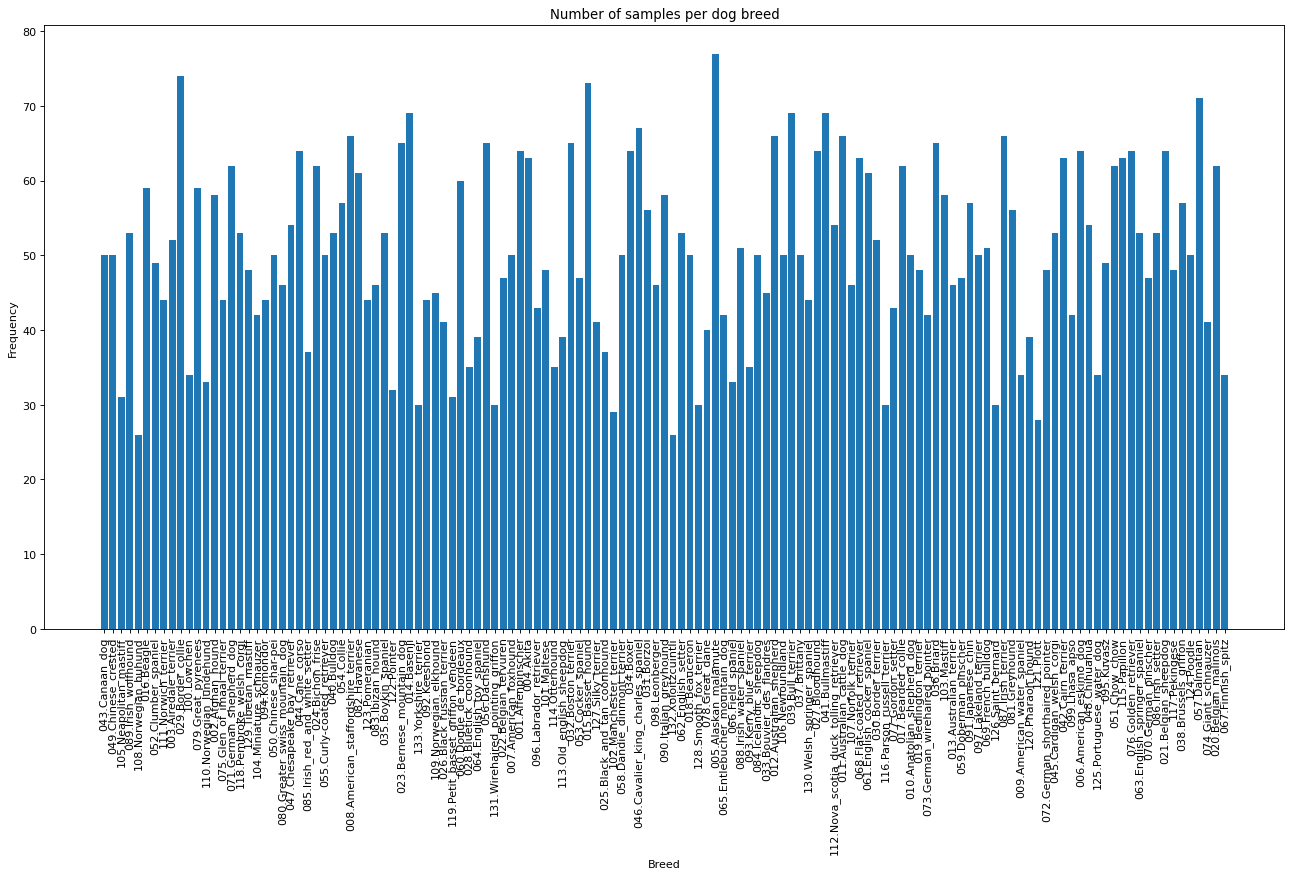

In [40]:
plt.figure(figsize=(20, 10), dpi=80)
plt.xticks(rotation='vertical')
plt.title("Number of samples per dog breed")
plt.xlabel('Breed')
plt.ylabel('Frequency')
plt.bar(dog_breeds,breed_count)

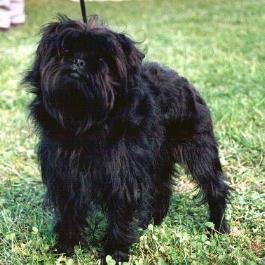

In [81]:
#Sample image
ipythonImage(filename='data/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg') 

In [12]:
#uploading the data into S3
from sagemaker import Session
session = Session()
bucket= session.default_bucket()

In [13]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

In [47]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./data/dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128])
}

In [7]:
role = sagemaker.get_execution_role()

In [8]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [30]:
tuner.fit(wait=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [31]:
best_estimator = tuner.best_estimator()


2022-02-03 07:51:57 Starting - Preparing the instances for training
2022-02-03 07:51:57 Downloading - Downloading input data
2022-02-03 07:51:57 Training - Training image download completed. Training in progress.
2022-02-03 07:51:57 Uploading - Uploading generated training model
2022-02-03 07:51:57 Completed - Training job completed


In [32]:
best_estimator

In [33]:
best_hyper = best_estimator.hyperparameters()

In [34]:
best_hyper

{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'lr': '0.001',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-02-03-06-28-39-090"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"ap-northeast-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-northeast-1-985768962182/pytorch-training-2022-02-03-06-28-39-090/source/sourcedir.tar.gz"'}

In [8]:
best_hyper = {'_tuning_objective_metric': '"average test loss"',
 'batch_size': '128',
 'lr': '0.001',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-02-03-06-28-39-090"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"ap-northeast-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-northeast-1-985768962182/pytorch-training-2022-02-03-06-28-39-090/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [9]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"})

In [10]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyper,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [11]:
estimator.fit(wait=True)

2022-02-03 11:23:30 Starting - Starting the training job...
2022-02-03 11:24:00 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-02-03 11:24:50 Starting - Preparing the instances for training...............
2022-02-03 11:27:31 Downloading - Downloading input data...
2022-02-03 11:28:03 Training - Downloading the training image..................
2022-02-03 11:31:04 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-03 11:30:46,740 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-03 11:30:46,762 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-03 11:30:48,2

UnexpectedStatusException: Error for Training job pytorch-training-2022-02-03-11-23-28-954: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train_model.py --batch_size 128 --lr 0.001"
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
  0%|          | 0.00/44.7M [00:00<?, ?B/s]  8%|â         | 3.70M/44.7M [00:00<00:01, 38.7MB/s] 19%|ââ        | 8.66M/44.7M [00:00<00:00, 46.6MB/s] 31%|âââ       | 13.9M/44.7M [00:00<00:00, 50.4MB/s] 43%|âââââ     | 19.1M/44.7M [00:00<00:00, 51.7MB/s] 55%|ââââââ    | 24.6M/44.7M [00:00<00:00, 54.2MB/s] 67%|âââââââ   | 29.8M/44.7M [00:00<00:00, 50.1MB/s] 78%|ââââââââ  | 34.7M/44.7M [00:00<00:00, 48.7MB/s] 88%|âââââââââ | 39.3M/44.7M [00:00<00:00, 48.0MB/s] 98%|ââââââââââ| 43.9M/44.7M [00:00<00:00, 45.8MB/s]100%|ââââââââââ| 44.7M/44.7M [00:00<00:00, 48.2MB/s]
Traceback (most recent call last):
  File "train_model.py", line 192, in <mo

In [ ]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

In [ ]:
trial.tensor_names()

In [ ]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [ ]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "nll_loss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [ ]:
! aws s3 ls {rule_output_path} --recursive

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()